<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [10]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [11]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [12]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [13]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.




——— 1. Visualización de las Series Temporales ———


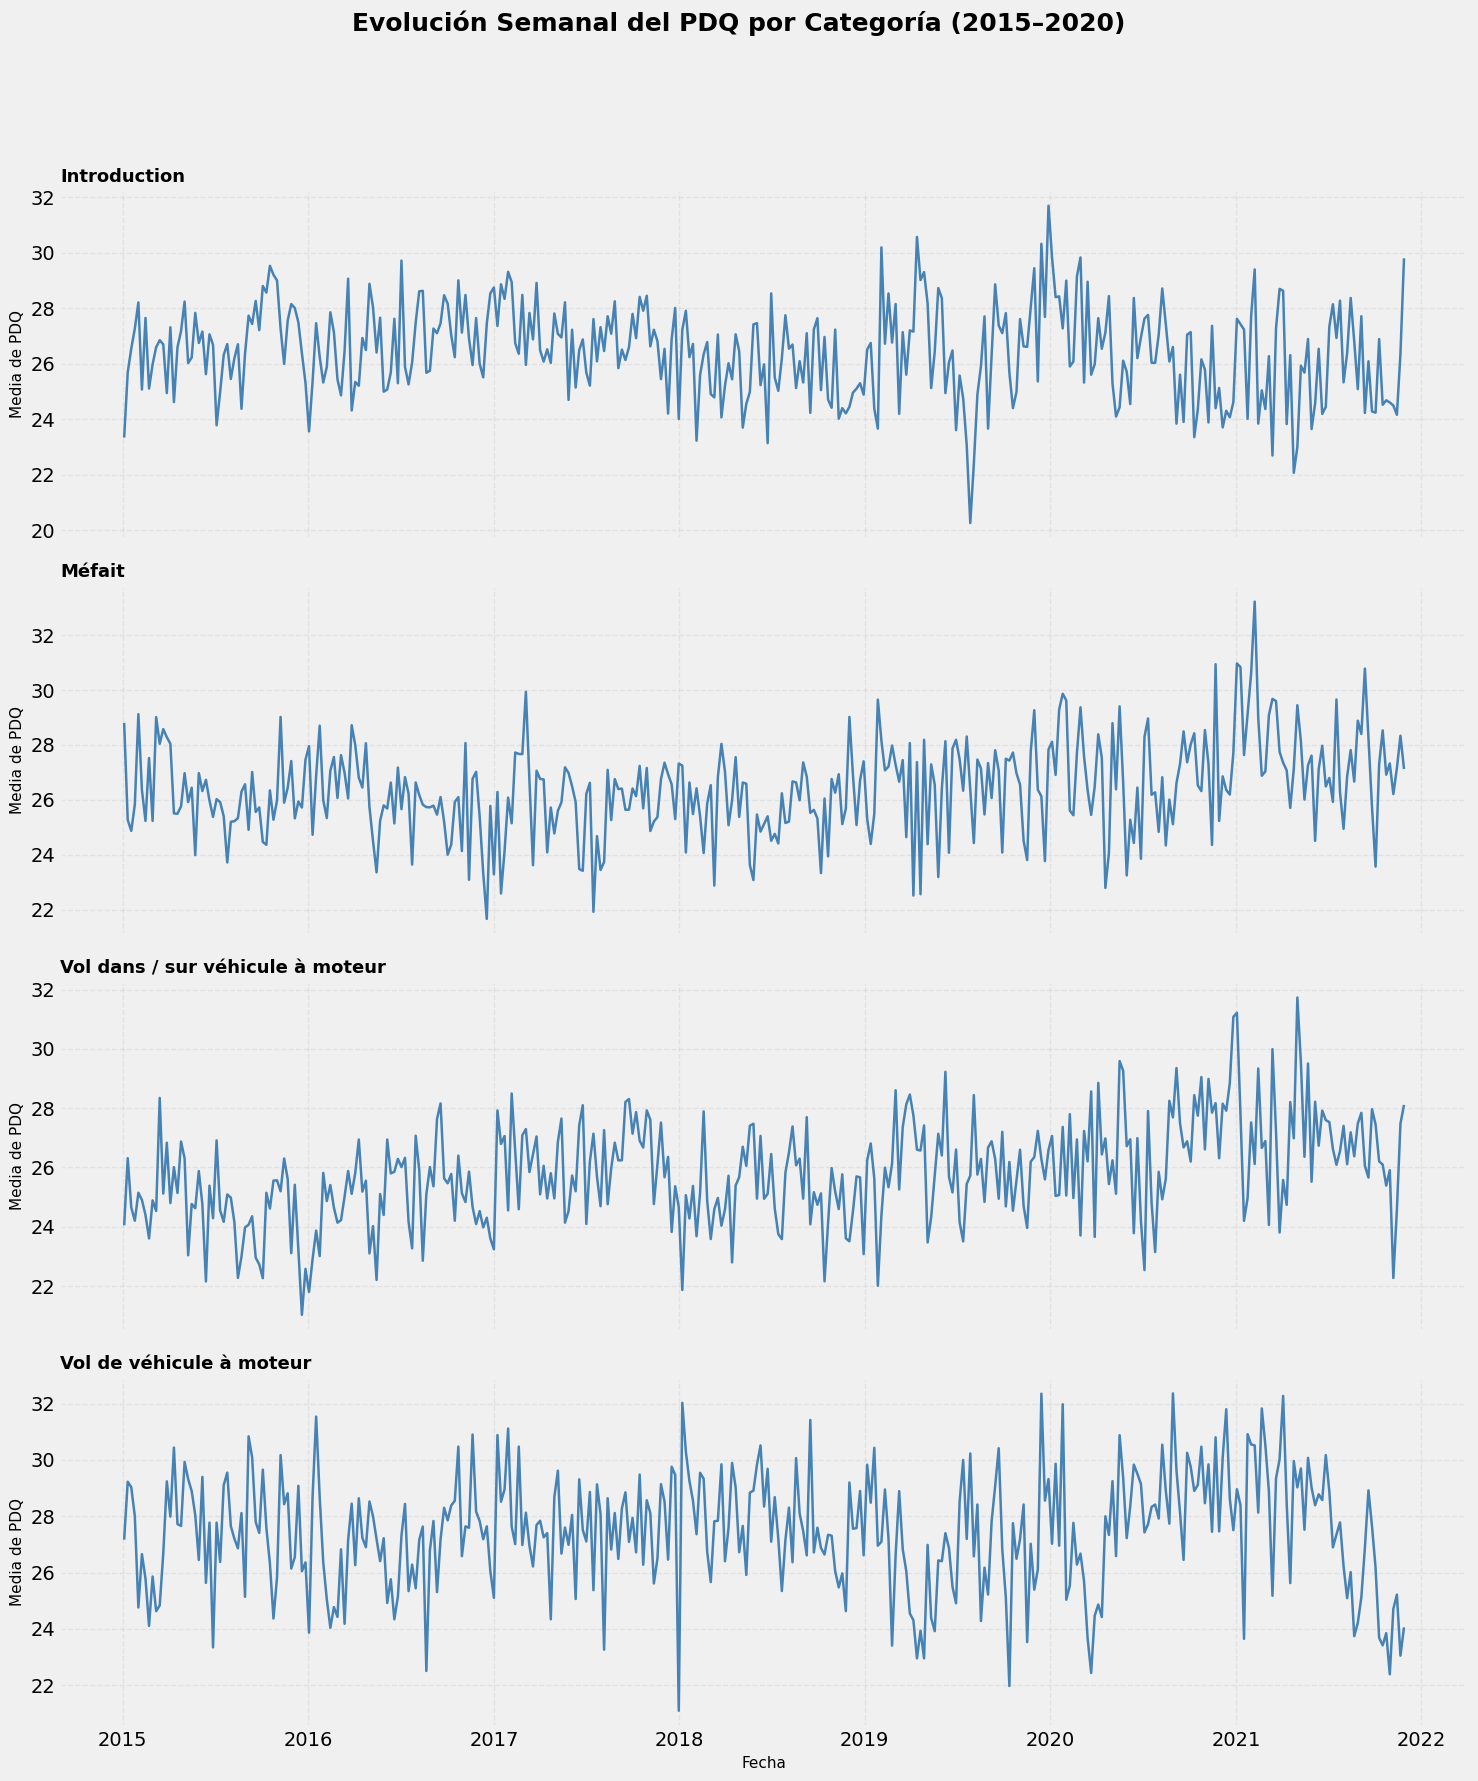

In [14]:
titles = validate_categorie
datasets = [y_s1, y_s2, y_s3, y_s4]
print("\n——— 1. Visualización de las Series Temporales ———")
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 18), sharex=True)
fig.suptitle("Evolución Semanal del PDQ por Categoría (2015–2020)",
             fontsize=18, fontweight="bold", y=1.02)

for i, (serie, title) in enumerate(zip(datasets, titles)):
    axes[i].plot(serie.index, serie['pdq'], color='steelblue', linewidth=1.8)
    axes[i].set_title(title, fontsize=13, loc='left', fontweight='semibold')
    axes[i].set_ylabel("Media de PDQ", fontsize=11)
    axes[i].grid(alpha=0.4, linestyle="--")

axes[-1].set_xlabel("Fecha", fontsize=11)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [15]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'


——— Serie seleccionada: Introduction ———

→ Análisis exploratorio: visualizando patrones y estacionalidad...



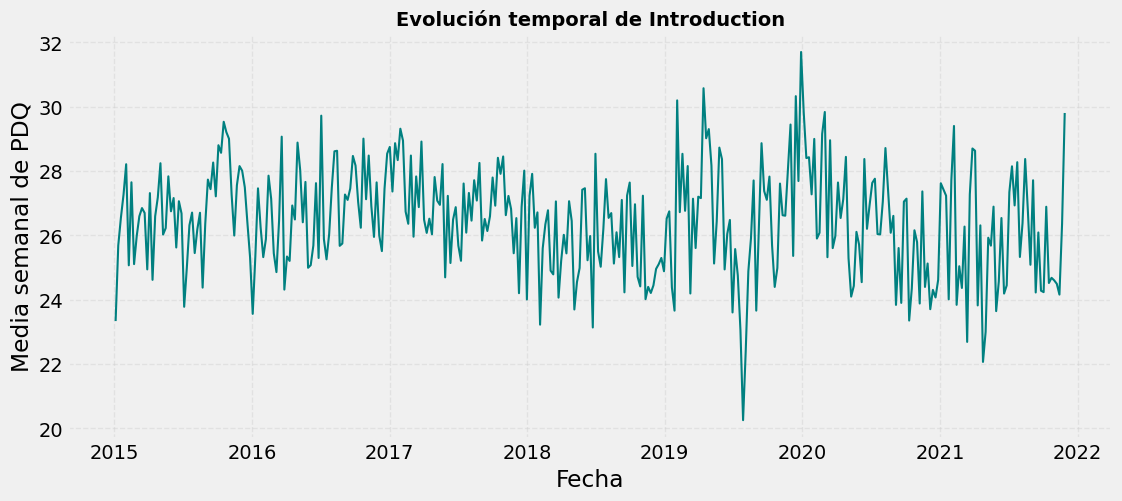


→ Descomposición estacional de la serie (tendencia, estacionalidad, residuo)...



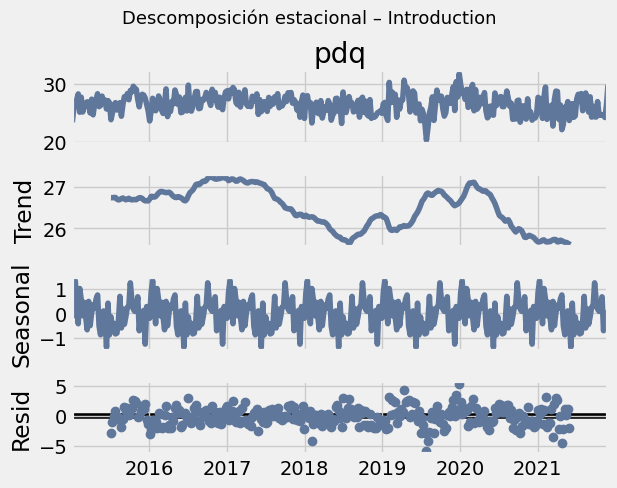


→ Ajustando modelos SARIMA con distintas configuraciones...

✅ Mejor modelo encontrado: SARIMA(0, 0, 0)x(0, 1, 1, 12) — AIC = 1137.88

→ Validación del modelo óptimo y predicciones...



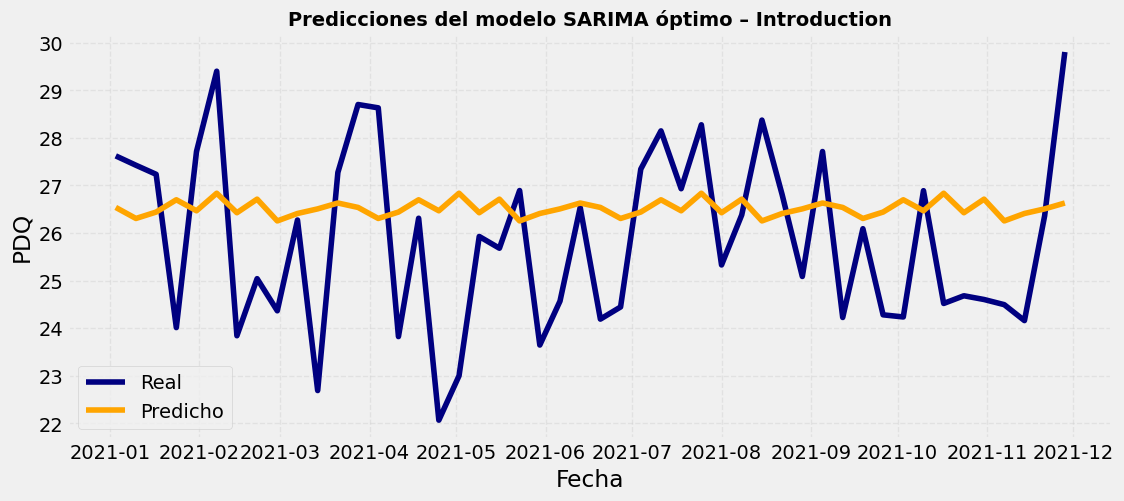


→ Analizando residuos del modelo (ruido blanco)...



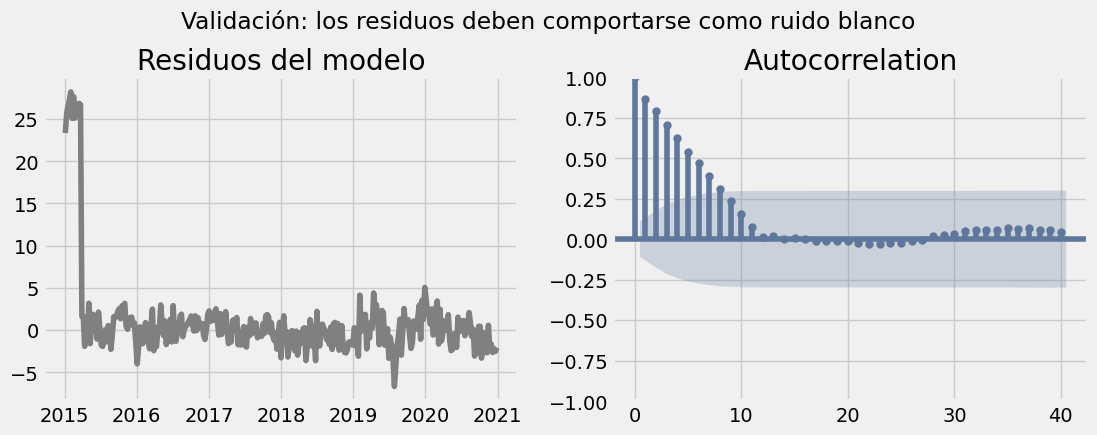

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
selected_series = y_s1.copy()
serie_name = validate_categorie[0]

print(f"\n——— Serie seleccionada: {serie_name} ———")
print("\n→ Análisis exploratorio: visualizando patrones y estacionalidad...\n")

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(selected_series.index, selected_series['pdq'], color='teal', linewidth=1.5)
ax.set_title(f"Evolución temporal de {serie_name}", fontsize=14, fontweight='bold')
ax.set_xlabel("Fecha")
ax.set_ylabel("Media semanal de PDQ")
ax.grid(alpha=0.4, linestyle='--')
plt.show()
print("\n→ Descomposición estacional de la serie (tendencia, estacionalidad, residuo)...\n")

serie_filled = selected_series['pdq'].ffill()
decomp = seasonal_decompose(serie_filled, model='additive', period=52)
decomp.plot()
plt.suptitle(f"Descomposición estacional – {serie_name}", y=1.02, fontsize=13)
plt.show()
print("\n→ Ajustando modelos SARIMA con distintas configuraciones...\n")

best_aic = float("inf")
best_model = None
best_param = None

for param in params[:8]:
    try:
        model_instance = SarimaModels(param)
        results = model_instance.fit_model(selected_series, target_date)
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = results
            best_param = param
    except Exception:
        continue

print(f"✅ Mejor modelo encontrado: SARIMA{best_param[0]}x{best_param[1]} — AIC = {best_aic:.2f}")
print("\n→ Validación del modelo óptimo y predicciones...\n")

model_instance = SarimaModels(best_param)
df_pred = model_instance.df_testig(selected_series, target_date)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_pred.index, df_pred['y'], label='Real', color='navy')
ax.plot(df_pred.index, df_pred['yhat'], label='Predicho', color='orange')
ax.set_title(f"Predicciones del modelo SARIMA óptimo – {serie_name}", fontsize=14, fontweight='bold')
ax.set_xlabel("Fecha")
ax.set_ylabel("PDQ")
ax.legend()
ax.grid(alpha=0.4, linestyle='--')
plt.show()

print("\n→ Analizando residuos del modelo (ruido blanco)...\n")

residuals = best_model.resid
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(residuals, color='gray')
axs[0].set_title("Residuos del modelo")
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[1])
plt.suptitle("Validación: los residuos deben comportarse como ruido blanco", y=1.05)
plt.show()




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


CmdStan install directory: /root/.cmdstan
CmdStan version 2.37.0 already installed
Test model compilation


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7yhrmsm4/dhu9p4zc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7yhrmsm4/10_ut6yh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21369', 'data', 'file=/tmp/tmp7yhrmsm4/dhu9p4zc.json', 'init=/tmp/tmp7yhrmsm4/10_ut6yh.json', 'output', 'file=/tmp/tmp7yhrmsm4/prophet_modele5ty29of/prophet_model-20251106235136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:51:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:51:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



 CmdStan activo en: /root/.cmdstan/cmdstan-2.37.0

——— 3. Modelado y comparación con Prophet ———
📊 Prophet – MAE: 1.7068 | RMSE: 2.0316 | MAPE: 6.70%

📈 Comparación de métricas:

       mae       mse      rmse    mape   maape   wmape   mmape   smape  \
0  1.64440  3.783200  1.945100  0.0654  0.0651  0.0635  0.0629  0.0635   
1  1.70682  4.127396  2.031599  6.7000     NaN     NaN     NaN     NaN   

     model  
0   SARIMA  
1  Prophet  


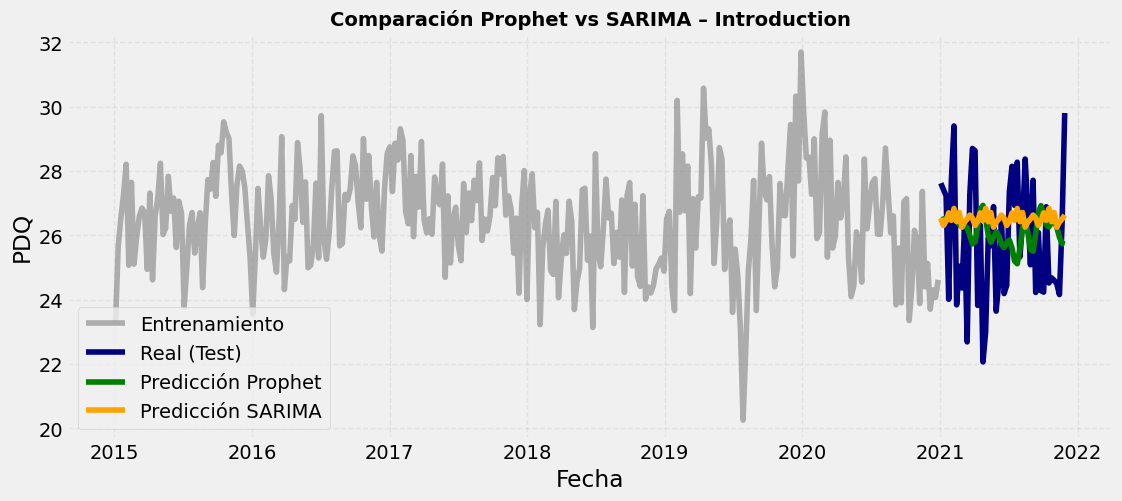

📁 Archivo 'metricas_comparativas_prophet.xlsx' exportado correctamente.

Conclusión:
- SARIMA puede modelar estructuras más complejas, pero Prophet es más ágil y automático.
- En esta serie, ambos muestran un desempeño similar, con Prophet destacando en facilidad de uso.



In [17]:
!pip uninstall -y prophet pystan cmdstanpy --quiet
!pip install prophet==1.1.5 cmdstanpy==1.2.4 --quiet
from cmdstanpy import install_cmdstan
install_cmdstan()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

if not hasattr(np, 'float'):
    np.float = float
if not hasattr(np, 'float_'):
    np.float_ = np.float64
if not hasattr(np, 'int'):
    np.int = int

import prophet
from prophet import Prophet
prophet.models.PROPhet_STAN_BACKEND = 'CMDSTANPY'

from cmdstanpy import cmdstan_path
print(f"\n CmdStan activo en: {cmdstan_path()}\n")
print("——— 3. Modelado y comparación con Prophet ———")

df_prophet = selected_series.copy().reset_index()

if 'index' in df_prophet.columns:
    df_prophet = df_prophet.rename(columns={'index': 'ds'})
elif 'date' in df_prophet.columns:
    df_prophet = df_prophet.rename(columns={'date': 'ds'})

df_prophet = df_prophet.rename(columns={'pdq': 'y'})

mask = df_prophet['ds'] < target_date
train = df_prophet[mask]
test = df_prophet[~mask]

model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model_prophet.fit(train)

future = model_prophet.make_future_dataframe(periods=len(test), freq='W')
forecast = model_prophet.predict(future)
pred_test = forecast.set_index('ds').loc[test['ds'], 'yhat']
y_true = test['y'].values
y_pred = pred_test.values
mae_p = mean_absolute_error(y_true, y_pred)
rmse_p = np.sqrt(mean_squared_error(y_true, y_pred))
mape_p = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"📊 Prophet – MAE: {mae_p:.4f} | RMSE: {rmse_p:.4f} | MAPE: {mape_p:.2f}%")
try:
    df_sarima_metrics = summary_metrics(df_pred)
    df_sarima_metrics['model'] = ['SARIMA']
except Exception:
    df_sarima_metrics = pd.DataFrame({
        'mae': [np.nan], 'mse': [np.nan],
        'rmse': [np.nan], 'mape': [np.nan],
        'model': ['SARIMA']
    })

df_prophet_metrics = pd.DataFrame({
    'mae': [mae_p],
    'mse': [mean_squared_error(y_true, y_pred)],
    'rmse': [rmse_p],
    'mape': [round(mape_p, 2)],
    'model': ['Prophet']
})

df_compare = pd.concat([df_sarima_metrics, df_prophet_metrics], ignore_index=True)
print("\n📈 Comparación de métricas:\n")
print(df_compare)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train['ds'], train['y'], label='Entrenamiento', color='gray', alpha=0.6)
ax.plot(test['ds'], test['y'], label='Real (Test)', color='navy')
ax.plot(test['ds'], y_pred, label='Predicción Prophet', color='green')

if 'df_pred' in locals():
    ax.plot(df_pred.index, df_pred['yhat'], label='Predicción SARIMA', color='orange')

ax.set_title(f"Comparación Prophet vs SARIMA – {serie_name}", fontsize=14, fontweight='bold')
ax.set_xlabel("Fecha")
ax.set_ylabel("PDQ")
ax.legend()
ax.grid(alpha=0.4, linestyle='--')
plt.show()
df_compare.to_excel("metricas_comparativas_prophet.xlsx", index=False)
print("📁 Archivo 'metricas_comparativas_prophet.xlsx' exportado correctamente.")
print("""
Conclusión:
- SARIMA puede modelar estructuras más complejas, pero Prophet es más ágil y automático.
- En esta serie, ambos muestran un desempeño similar, con Prophet destacando en facilidad de uso.
""")
